Import the required Libraries

In [45]:
import cv2
import matplotlib.pyplot as plt

Initialize lists to store intensity of each channel frame wise in sequence.

In [46]:
red_intensities = []
blue_intensities = []
green_intensities = []
frame_number = []

Create a video capture object

In [47]:
cap = cv2.VideoCapture('Nisarg.mp4')

Loop through the video to calculate average intensity of each channel in different frames and store the value to the list.
The average intensity is calculated as sum of all pixels of that channel in an image divided by total number of pixels in the image.
Now as the heart beats, the intensity gradually decreases and increases that can be seen from the graph obtained after the loop runs through the video.

It was observed that no significant component of green and blue channels were there in the videos and a pattern was not formed so they are commented out, but can still be used in some cases if there is any discrepancy in red channel.


In [48]:
while(True):
    try:
        ret, frame = cap.read()
        #Split the channels
        b, g, r = cv2.split(frame)

        #Flatten the image to calculate average easily
        r=r.flatten()
        g=g.flatten()
        b=b.flatten()
        
        #calculate average intensity of each channel
        average_red = sum(r) / len(r)
        #average_blue = sum(b) / len(b)
        #average_green = sum(g) / len(g)

        #APPEND THE AVERAGE TO THE LIST TO PLOT AND ANALYSE FURTHER
        red_intensities.append(average_red)
        #blue_intensities.append(average_blue)
        #green_intensities(average_green)
        
        #cv2.imshow('Video',frame)
        k=cv2.waitKey(1) & 0xFF
        if k==27:
            break

    #There will be an exception when the video ends so the except block breaks out of the loop
    except Exception as e:
        print(e)
        cv2.destroyAllWindows()
        break

not enough values to unpack (expected 3, got 0)


Now we will skip data from initial 150 frames (approx first 5 seconds if the video is 30FPS) to get cleaner data because usualy in this part the user has not properly put finger on the camera or is adjusting the position.

In [49]:
red_intensities = red_intensities[150:]


Now, we will plot the graph of frame number vs average red channel intensity in that frames.



Text(0, 0.5, 'Average red intensity in frame')

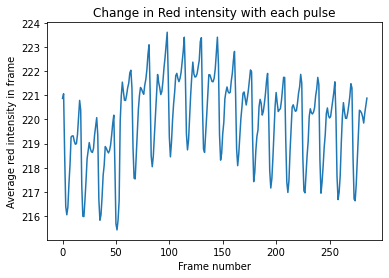

In [50]:
for i in range(len(red_intensities)):
  frame_number.append(i)

plt.plot(frame_number, red_intensities)
plt.title("Change in Red intensity with each pulse")
plt.xlabel('Frame number')
plt.ylabel('Average red intensity in frame')


The graph is uneven so minimas and maximas are difficult to determine. To solve this problem moving average is applied on the list containing average intensities.

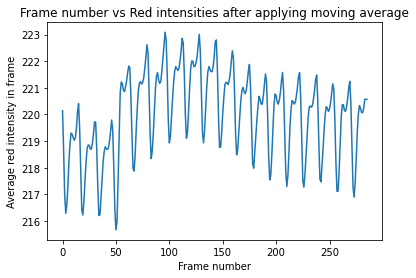

In [51]:
moving_avg_red = [] #After taking average of neighbouring elements the new value will be stored in this list
neighbour_size = 3 #Number of neighbours to take average, Increasing this value creates a smoother graph

i = 0 #counter variable
#loop through the list and calculate average of first five elements and append 
#it to another list, then calculate average of next five elements and so on.
while i < len(red_intensities) - neighbour_size + 1:
    neighbours = red_intensities[i : i + neighbour_size]
    neighbour_average = round(sum(neighbours) / neighbour_size, 2)
    moving_avg_red.append(neighbour_average)      
    i += 1
for i in range(neighbour_size - 1):
	moving_avg_red.append(moving_avg_red[len(moving_avg_red) - 1])

plt.title("Frame number vs Red intensities after applying moving average")
plt.xlabel('Frame number')
plt.ylabel('Average red intensity in frame')
plt.plot(frame_number, moving_avg_red)
plt.show()

In the above graph each spike corresponds to a heart beat, so to calculate number of beats we can either calculate number of peaks or number of minimas. Here I have implemented a simple minima detection algorithm to count the number of pulses.

To detect minima five consequtive data points are taken and the middle one should be smaller then its neighbours, and the outer most points should be greated than inner points.

For example if [p1,p2,p3,p4,p5] are there then for p3 to be minima, p1>p2>p3<p4<p5 condition must be satisfyed. then the condition is checked for next five points and so on whole list is traversed.



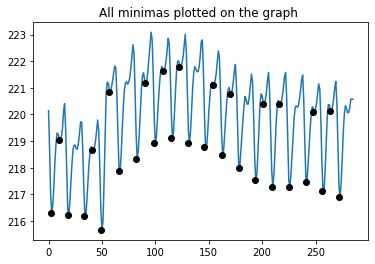

In [52]:
index=0 #counter variable
minima=[] #the minima points will be added to this list
minima_index=[] #frame_number of minima points will be added to this list so plot them on intensity graph

#Loop through the data points
while True:
    if index + 4 < len(moving_avg_red):
        #Take five consequtive data points and compare them with each other and the center one will be minima if previous two and itself
        #are in decending order and next tow with itself is in ascending order
        left_left = moving_avg_red[index]
        left = moving_avg_red[index+1]
        mid = moving_avg_red[index+2]
        right = moving_avg_red[index+3]
        right_right = moving_avg_red[index+4]
        #Condition for a point to be minima
        if (left_left > left) and (left > mid) and (right > mid) and (right_right > right):
            #If the condition is satifyed then append it to the list
            minima_index.append(index + 1)
            minima.append(mid)
    #break the loop to avoid list index out of range 
    if index >= len(moving_avg_red):
        break
    index += 1

#plot the minimas on the graph
plt.plot(frame_number, moving_avg_red)
plt.title("All minimas plotted on the graph ")
plt.plot(minima_index, minima, 'o', color='black')
plt.show()


From the above graph we can see that there are some unwanted minimas also detected above ther required points. So to increase the accuracy of our program we will filter them out using a simple algorithm. If the next minima is grater than current minima + 1.7 then it is redundant and is popped out.

POPPED  0
POPPED  2
POPPED  3
POPPED  5
POPPED  6
POPPED  7
POPPED  9
POPPED  10
POPPED  12
POPPED  13
POPPED  15
POPPED  16


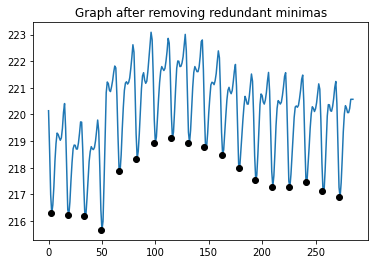

In [53]:
index=0
for i in minima:
    if i != minima[len(minima) - 1]:
        if minima[index + 1] > minima[index] + 1.7:
            minima.pop(index + 1)
            minima_index.pop(index + 1)
            print("POPPED ", index)
    index+=1

plt.plot(frame_number, moving_avg_red)
plt.title("Graph after removing redundant minimas")
plt.plot(minima_index, minima, 'o', color='black')
plt.show()

Now number of elements in the list "minima" is the number of beats and number of elements in the list "frame_number" is the number of frames. So to calculate pulse beats per minute we will need to know the frame rate of the video. 

The pulse rate is calculated as : (60 x number_of_minimas)/ ((number_of_frames)/frame_rate)

In [54]:
#find out frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)
#finally calculate the pulse rate
pulse_rate = (len(minima_index) * 60) / (len(moving_avg_red) / fps)
print("The pulse rate is: ", pulse_rate)

The pulse rate is:  101.4011496351033


Written by:

Nisarg Panchal (19bee070@nirmauni.ac.in)

Electrical Engineering 2019-2023, 

Nirma University 

